In [16]:
import os, glob
import pandas as pd
import numpy as np

# Adjust this to your processed root
PROC_ROOT = r"C:\Users\Kiera\Amdar\Project - Sentiment-Driven\data\RedditDumps\processed"

# Find all parquet shards
files = glob.glob(os.path.join(PROC_ROOT, "*", "submissions_*.parquet"))
assert files, "No processed parquet files found. Did the filter script run?"

dfs = []
for fp in files:
    df_part = pd.read_parquet(fp)
    dfs.append(df_part)

df = pd.concat(dfs, ignore_index=True)

# Ensure expected columns exist
expected = ['id','created_utc','subreddit','title','selftext','score',
            'num_comments','author','permalink','url','over_18']
missing = [c for c in expected if c not in df.columns]
if missing:
    print("Missing columns:", missing)

# Convert timestamps to pandas datetime
df["created_dt"] = pd.to_datetime(df["created_utc"], unit="s", utc=True)
df["date"] = df["created_dt"].dt.date
df["hour_utc"] = df["created_dt"].dt.hour

# Coerce numerics safely
for c in ["score", "num_comments"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

print("Rows:", len(df))
df.sample(5)


Rows: 83220


,id,created_utc,subreddit,title,selftext,score,num_comments,author,permalink,url,over_18,created_dt,date,hour_utc
19504,1l0pc6u,1748785558,stocks,18M maxed out tfsa,[removed],1,0,Rare_Fox3007,/r/stocks/comments/1l0pc6u/18m_maxed_out_tfsa/,https://www.reddit.com/r/stocks/comments/1l0pc...,False,2025-06-01 13:45:58+00:00,2025-06-01,13
53640,1m6z78w,1753242810,stocks,HG.V The Graphene Sleeper That Could 100x?,[removed],1,0,Present_Cod5701,/r/stocks/comments/1m6z78w/hgv_the_graphene_sl...,https://www.reddit.com/r/stocks/comments/1m6z7...,False,2025-07-23 03:53:30+00:00,2025-07-23,3
761,1kcj5t7,1746132333,investing,$500 /share ETF vs. $20 /share ETF,[removed],1,1,Large_Patient_9332,/r/investing/comments/1kcj5t7/500_share_etf_vs...,https://www.reddit.com/r/investing/comments/1k...,False,2025-05-01 20:45:33+00:00,2025-05-01,20
77804,1mwjzsq,1755802932,wallstreetbets,PLTR insightful interview from Alphasense,Good material for the ones looking at PLTR!\n\...,0,1,hugomm175,/r/wallstreetbets/comments/1mwjzsq/pltr_insigh...,https://x.com/AlphaSenseInc/status/19585397163...,False,2025-08-21 19:02:12+00:00,2025-08-21,19
32019,1lir5k4,1750709742,StockMarket,"""War"" is over. Stock pump?",Always thank your enemy for letting you know o...,940,377,atlasmountsenjoyer,/r/StockMarket/comments/1lir5k4/war_is_over_st...,https://i.redd.it/ld8x1jmwiq8f1.jpeg,False,2025-06-23 20:15:42+00:00,2025-06-23,20


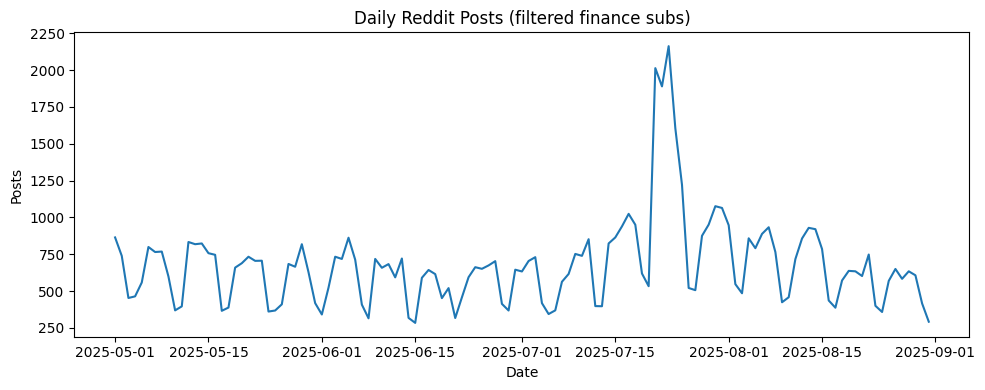

In [17]:
import matplotlib.pyplot as plt

daily_posts = df.groupby("date")["id"].count().rename("posts")

plt.figure(figsize=(10,4))
daily_posts.plot()
plt.title("Daily Reddit Posts (filtered finance subs)")
plt.xlabel("Date")
plt.ylabel("Posts")
plt.tight_layout()


,total_score,total_comments,posts
date,,,
2025-05-01,123158,54069,864
2025-05-02,77830,46552,739
2025-05-03,70617,12003,453
2025-05-04,55114,21726,464
2025-05-05,65373,36820,558


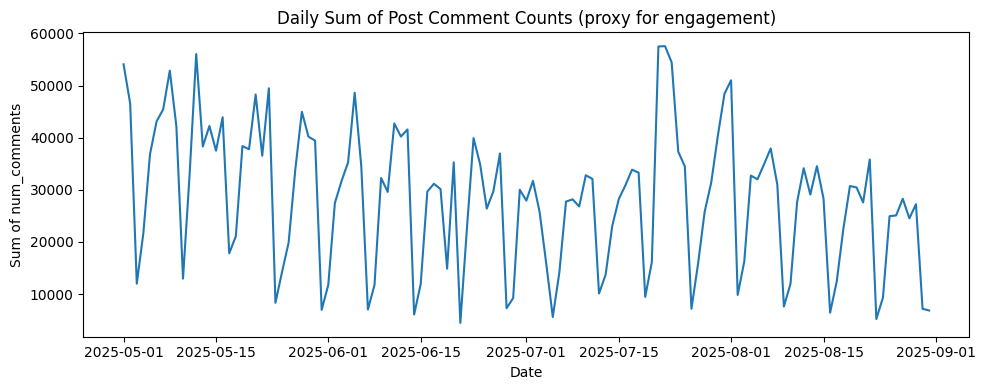

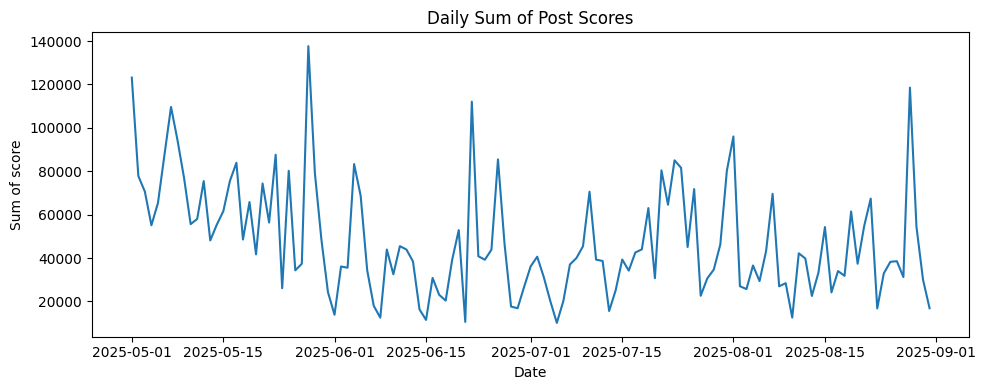

In [18]:
daily_eng = df.groupby("date").agg(
    total_score=("score","sum"),
    total_comments=("num_comments","sum"),
    posts=("id","count"),
)
display(daily_eng.head())

# Two separate simple plots (one per the tool's guidance: one chart per figure)
plt.figure(figsize=(10,4))
daily_eng["total_comments"].plot()
plt.title("Daily Sum of Post Comment Counts (proxy for engagement)")
plt.xlabel("Date")
plt.ylabel("Sum of num_comments")
plt.tight_layout()

plt.figure(figsize=(10,4))
daily_eng["total_score"].plot()
plt.title("Daily Sum of Post Scores")
plt.xlabel("Date")
plt.ylabel("Sum of score")
plt.tight_layout()


subreddit
wallstreetbets    41439
stocks            15372
investing         11234
Trading           11149
StockMarket        4026
Name: count, dtype: int64

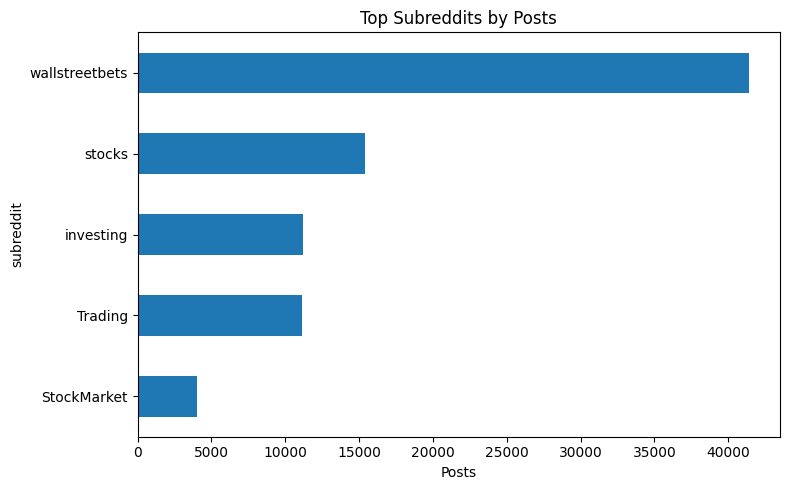

In [19]:
topN = 15
sub_counts = df["subreddit"].value_counts().head(topN)
display(sub_counts)

plt.figure(figsize=(8,5))
sub_counts.sort_values().plot(kind="barh")
plt.title(f"Top Subreddits by Posts")
plt.xlabel("Posts")
plt.tight_layout()


,posts,avg_comments,avg_score
subreddit,,,
wallstreetbets,41439,63.799971,81.513960
stocks,15372,21.689175,54.885441
investing,11234,14.786541,14.533826
Trading,11149,5.299758,5.181541
StockMarket,4026,72.071783,362.322156


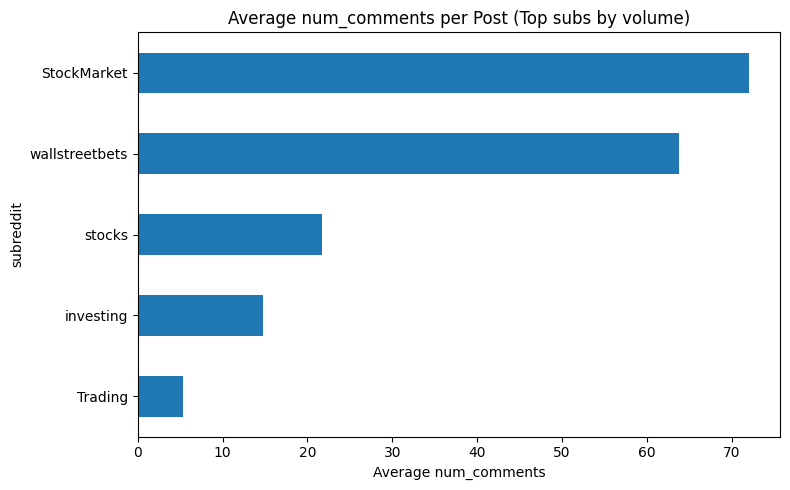

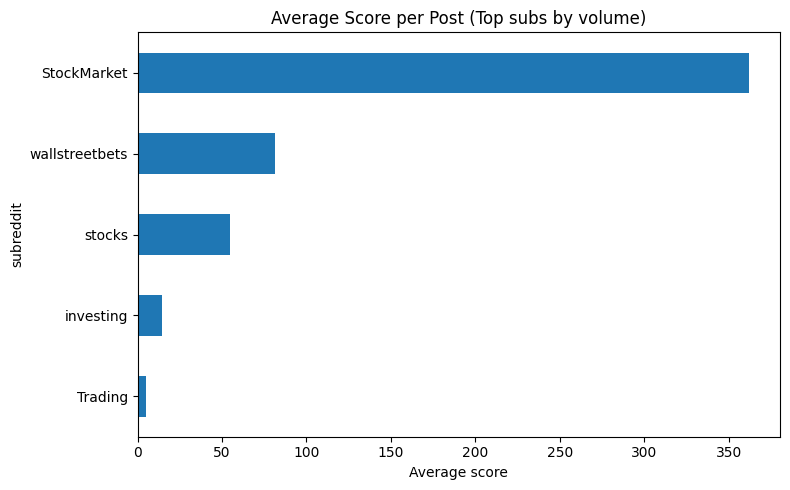

In [20]:
# Focus on subreddits with enough posts for stable averages
min_posts = 50
agg = df.groupby("subreddit").agg(
    posts=("id","count"),
    avg_comments=("num_comments","mean"),
    avg_score=("score","mean")
)
agg = agg[agg["posts"] >= min_posts].sort_values("posts", ascending=False)

display(agg.head(10))

# Plot avg comments
plt.figure(figsize=(8,5))
agg.head(15)["avg_comments"].sort_values().plot(kind="barh")
plt.title("Average num_comments per Post (Top subs by volume)")
plt.xlabel("Average num_comments")
plt.tight_layout()

# Plot avg score
plt.figure(figsize=(8,5))
agg.head(15)["avg_score"].sort_values().plot(kind="barh")
plt.title("Average Score per Post (Top subs by volume)")
plt.xlabel("Average score")
plt.tight_layout()


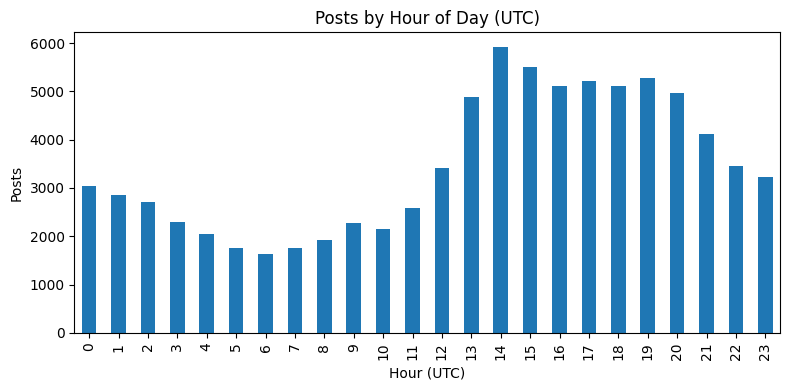

In [21]:
hourly = df.groupby("hour_utc")["id"].count().rename("posts")

plt.figure(figsize=(8,4))
hourly.plot(kind="bar")
plt.title("Posts by Hour of Day (UTC)")
plt.xlabel("Hour (UTC)")
plt.ylabel("Posts")
plt.tight_layout()


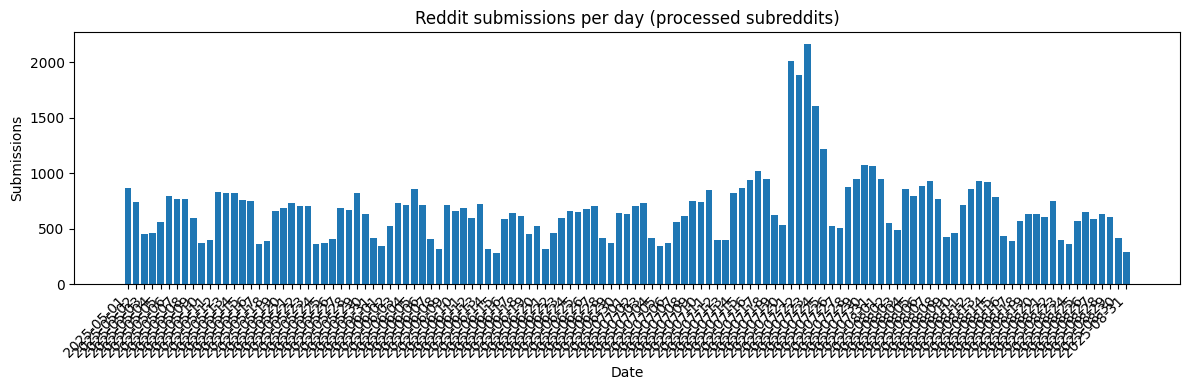

In [22]:
daily = df.groupby("date").size().rename("count").reset_index()

plt.figure(figsize=(12,4))
plt.bar(daily["date"].astype(str), daily["count"])
plt.title("Reddit submissions per day (processed subreddits)")
plt.xlabel("Date")
plt.ylabel("Submissions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

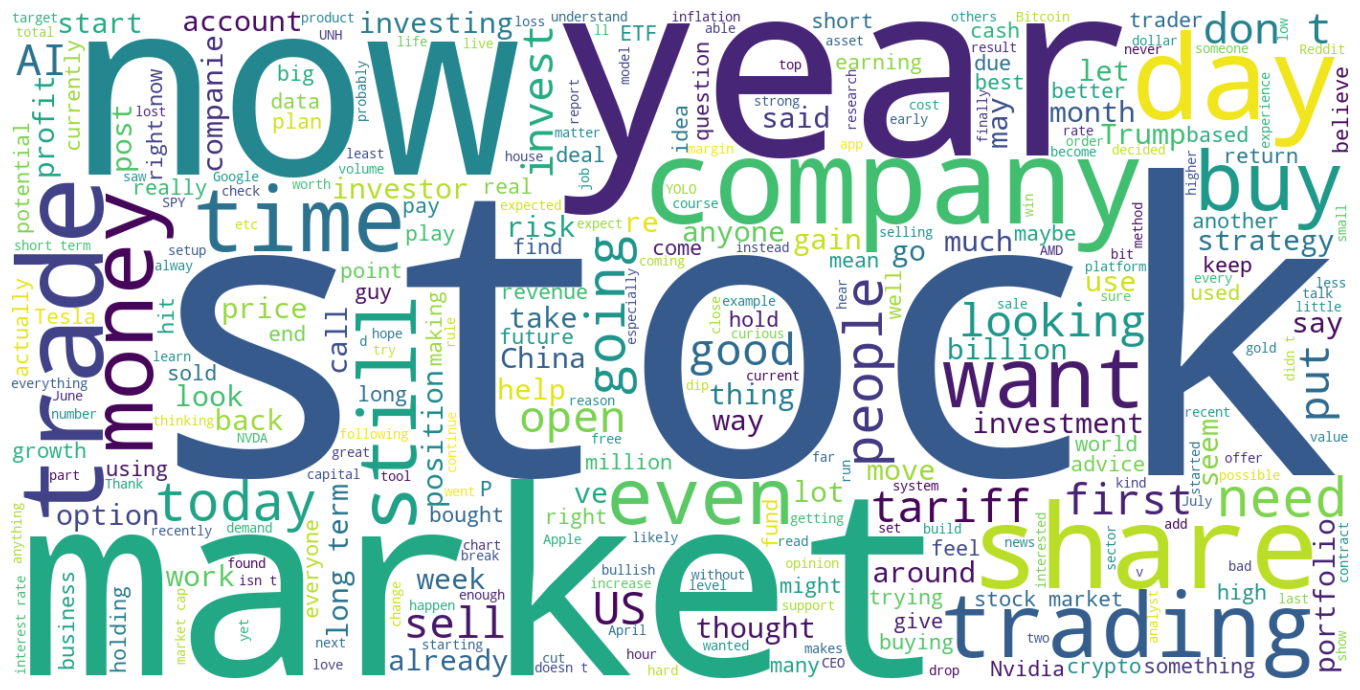

In [24]:
# Word cloud of Reddit titles + selftext
from wordcloud import WordCloud, STOPWORDS
import re
import matplotlib.pyplot as plt

text_series = (df["title"].fillna("") + " " + df["selftext"].fillna(""))
full_text = " ".join(text_series.tolist())
full_text = re.sub(r"http\S+|www\.\S+", " ", full_text)

# stopwords
stops = STOPWORDS.union({
    "the","and","for","with","from","that","this","are","was","were",
    "to","of","in","on","at","as","it","is","be","by","or","an","a",
    "im","ive","dont","doesnt","cant","you","your","we","they","i",
    "amp","nbsp","like","just","get","got","would","one","edit",
    "thanks","think","know","new","will","see","make","made", 'removed', 's', 'm', 'u'
})

wc = WordCloud(
    width=1400, height=700,
    background_color="white",
    stopwords=stops,
    max_words=300
).generate(full_text)

plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()


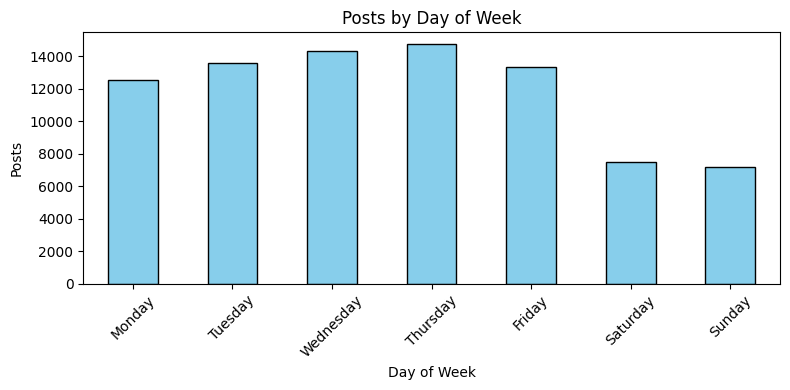

In [25]:
import matplotlib.pyplot as plt

# Group by weekday (0=Monday ... 6=Sunday)
weekday_counts = df.groupby(df["created_dt"].dt.day_name())["id"].count()

# Reorder to natural week order
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekday_counts = weekday_counts.reindex(order)

plt.figure(figsize=(8,4))
weekday_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Posts by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
